# Exercise 6.3: Neural Networks in Keras

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# See https://keras.io/
# for extennsive documentation
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

plt.style.use("seaborn-v0_8")

# GPU list
gpus = tf.config.list_physical_devices('GPU')

# Select GPU 1
tf.config.set_visible_devices(gpus[1], 'GPU')

Let us visit the problem of wine quality prediction previously encountered one final time. After linear regression and a self-made network, we can now explore the comfort provided by the Keras library.

In [3]:
# The code snippet below is responsible for downloading the dataset to
# Google. You can directly download the file using the link
# if you work with a local anaconda setup
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv --no-check-certificate

File ‘winequality-white.csv’ already there; not retrieving.



In [4]:
# load all examples from the file
data = np.genfromtxt("winequality-white.csv", delimiter=";", skip_header=1)

print(f"{data.shape = } \n")

# Prepare for proper training
rng = np.random.default_rng(1234)
rng.shuffle(data)  # randomly sort examples

# take the first 3000 examples for training
# (remember array slicing from last week)
X_train = data[:3000, :11]  # all features except last column
y_train = data[:3000, 11]  # quality column

# and the remaining examples for testing
X_test = data[3000:, :11]  # all features except last column
y_test = data[3000:, 11]  # quality column

# Compute mean and std *only on the training features*
# Normalization helps gradient-based optimizers converge faster
# and prevents features with large numeric ranges from dominating others.

# Compute mean and std *only on the training features*
mean = np.mean(X_train, axis=0)
std  = np.std(X_train, axis=0)
print("Mean shape:", mean.shape)

# Apply z-score normalization to train and test
X_train = (X_train - mean) / std
X_test  = (X_test  - mean) / std 

print("First example:")
print("Features:", X_train[0])
print("Quality:", y_train[0])

data.shape = (4898, 12) 

Mean shape: (11,)
First example:
Features: [-0.06260036 -0.8790185   3.07923825  2.14845111 -0.17940754 -0.849691
 -0.55742249  1.24376342 -2.24084287  0.07359793 -0.80619348]
Quality: 6.0


Below is the simple network from exercise 4.1 implemented using Keras. In addition to the network we define the loss function and optimiser.

In [5]:
# See: https://keras.io/api/models/sequential/ and
# https://keras.io/api/layers/core_layers/dense/
# We can use the Sequential class to very easiliy

# ============================
# Model building: Baseline and Optimized
# ============================

# Model 1: Baseline
# -----------------
# This is a simple feed-forward neural network with:
# - 2 hidden layers
# - 20 neurons per layer
# - ReLU activation function
# - Mean Squared Error loss
# - Adam optimizer with learning rate 0.001
# 
# The goal of this baseline model is to have a reference performance
# against which we can compare the optimized version.
nb_nodes = 20
nb_layers = 2
activation = "relu"

model_basic = Sequential()
# First layer: 11 input features -> 20 neurons
model_basic.add(Dense(nb_nodes, input_dim=11, activation=activation))

# Add additional hidden layers (if nb_layers > 1)
for i in range(1, nb_layers):
    model_basic.add(Dense(nb_nodes, activation=activation))

# Output layer: single neuron for regression, linear activation
model_basic.add(Dense(1, activation='linear'))

# Compile model with Adam optimizer and MSE loss
adam = keras.optimizers.Adam(learning_rate=0.001)
model_basic.compile(
    loss='mse',  # mean squared error suitable for regression
    optimizer=adam
)


# Model 2: Optimized
# -----------------
# This model applies techniques to improve regression performance:
# - 4 hidden layers with 50 neurons each
# - ReLU activation
# - L2 regularization to reduce overfitting
# - (Optional) Dropout for additional regularization
# - Adam optimizer with learning rate 0.001
# 
# These modifications were chosen after experimenting with different
# numbers of layers, neurons, and regularization parameters, 
# selecting the configuration that gave the best correlation.
nb_nodes_opt = 50
nb_layers_opt = 4
activation_opt = "relu"

model_opt = Sequential()
model_opt.add(Dense(nb_nodes_opt, input_dim=11, activation=activation_opt))

for i in range(1, nb_layers_opt):
    model_opt.add(Dense(nb_nodes_opt,
                        activation=activation_opt,
                        kernel_regularizer=l2(0.001)))
    # model_opt.add(Dropout(0.3))

model_opt.add(Dense(1, activation='linear'))

adam = keras.optimizers.Adam(learning_rate=0.001)
model_opt.compile(
    loss='mse',
    optimizer=adam
)

/home/damian/miniforge3/envs/adl/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1763319576.314624 2487373 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46765 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:b3:00.0, compute capability: 8.6


# Training and evaluation below

The code below trains the network for 5 epochs using the loss function and optimiser defined above. Each example is individually passed to the network

In [6]:
# Parameters:
# - epochs=100: number of complete passes through the training dataset.
#   Increasing epochs allows the model to learn more, but too many can cause overfitting.
# - batch_size=64: number of samples processed before updating model weights.
#   Smaller batch sizes introduce more noise in gradient estimates, which can improve
#   generalization but slow convergence. Larger batch sizes provide smoother
#   gradient updates but may require more memory and can sometimes lead to poorer generalization.
#
# We experimented with different numbers of epochs and batch sizes,
# observing that these values provide a good balance between
# convergence speed and training stability.

history_basic = model_basic.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100, batch_size=64, verbose=0)

I0000 00:00:1763319583.749126 2487631 service.cc:152] XLA service 0x7f8ffc003330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763319583.749153 2487631 service.cc:160]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-11-16 19:59:43.784263: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763319583.923467 2487631 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1763319585.976378 2487631 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [7]:
# We performed the same training procedure as for the baseline model:
# - Same number of epochs (100) and batch size (64)
# 
# The goal here was to apply the same analysis to the optimized model
# to compare its performance with the baseline.

history_opt = model_opt.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100, batch_size=64, verbose=0)

In [8]:
# The history object returned by the model training above
# contains the values of the loss function (the mean-squared-error)
# at different epochs
# We discard the first epoch as the loss value is very high,
# obscuring the rest of the distribution

train_loss_basic = history_basic.history["loss"][1:]
test_loss_basic  = history_basic.history["val_loss"][1:]
train_loss_opt   = history_opt.history["loss"][1:]
test_loss_opt    = history_opt.history["val_loss"][1:]

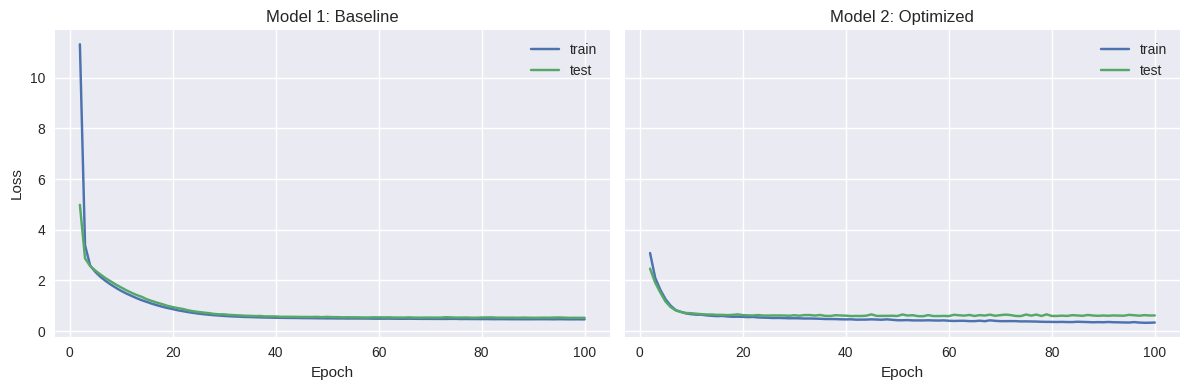

In [9]:
epochs_basic = range(2, 2 + len(train_loss_basic))
epochs_opt   = range(2, 2 + len(train_loss_opt))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# --- Basic ---
axes[0].plot(epochs_basic, train_loss_basic, label="train")
axes[0].plot(epochs_basic, test_loss_basic, label="test")
axes[0].set_title("Model 1: Baseline")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

# --- Optimized ---
axes[1].plot(epochs_opt, train_loss_opt, label="train")
axes[1].plot(epochs_opt, test_loss_opt, label="test")
axes[1].set_title("Model 2: Optimized")
axes[1].set_xlabel("Epoch")
axes[1].legend()

plt.tight_layout()
plt.show()

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


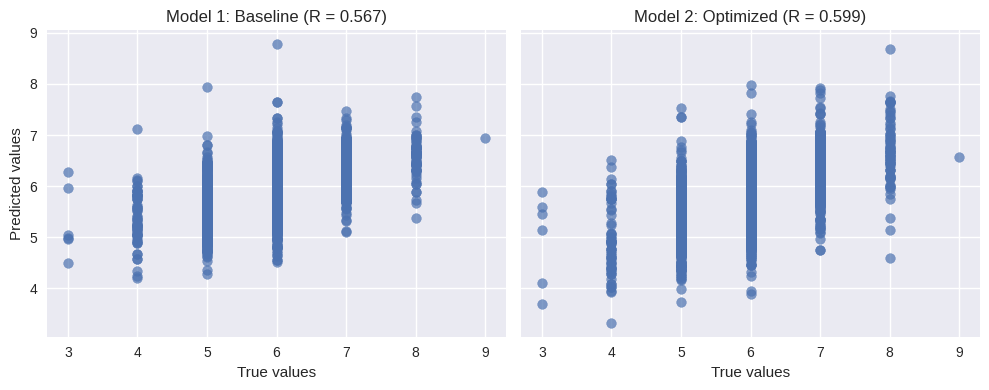

In [10]:
y_pred_basic = model_basic.predict(X_test)[:, 0]
y_pred_opt   = model_opt.predict(X_test)[:, 0]

corr_basic = np.corrcoef(y_pred_basic, y_test)[0, 1]
corr_opt   = np.corrcoef(y_pred_opt, y_test)[0, 1]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# --- Basic ---
axes[0].scatter(y_test, y_pred_basic, alpha=0.7)
axes[0].set_title(f"Model 1: Baseline (R = {corr_basic:.3f})")
axes[0].set_xlabel("True values")
axes[0].set_ylabel("Predicted values")

# --- Optimized ---
axes[1].scatter(y_test, y_pred_opt, alpha=0.7)
axes[1].set_title(f"Model 2: Optimized (R = {corr_opt:.3f})")
axes[1].set_xlabel("True values")

plt.tight_layout()
plt.show()

In [11]:
corr_base = np.corrcoef(y_pred_basic, y_test)[0, 1]
corr_opt = np.corrcoef(y_pred_opt, y_test)[0, 1]

print(f"Correlation (base model):       {corr_base:.4f}")
print(f"Correlation (optimized model):  {corr_opt:.4f}")

Correlation (base model):       0.5669
Correlation (optimized model):  0.5989


In [12]:
# ============================
# Final observations
# ============================

# After analyzing the training and validation results, we can see that
# the optimized model achieved slightly better correlation compared to the baseline.
# However, the improvement is not very significant.
#
# This illustrates an important point in practical deep learning:
# manually tuning model parameters (number of layers, neurons, regularization,
# learning rate, batch size, etc.) is not a trivial task and often requires
# extensive experimentation. Automated methods like hyperparameter optimization
# can help, but even then finding the best configuration is challenging.


# Problems

* Use the notebook as starting point. It already contains the simple network from Exercise 4.1 implemented in Keras.

* Currently, SGD is used without momentum. Try training with a momentum term. Replace SGD with the Adam optimizer and train using that. (See: https://keras.io/api/optimizers/)
* Add two more hidden layers to the network (you can choose the number of nodes but make sure to apply the ReLu activation function after each) and train again.
* Test differet numbers of examples (i.e. change the batch batch size) to be simulataneously used by the network.
* (bonus) optimize the network architecture to get the best correlation coefficient. (Let's see who gets the most out of the data).